In [1]:
from CNNectome.validation.organelles.segmentation_metrics import Evaluator,EvaluationMetrics
import h5py
import numpy as np
import csv
import os
from skimage import io
%matplotlib inline 
from matplotlib import pyplot as plt
import pandas as pd


In [143]:
directories=["/groups/cosem/cosem/annotations/training/",
"/groups/cosem/cosem/annotation_and_analytics/training/rymert/",
"/groups/cosem/cosem/annotation_and_analytics/training/forknalln/",
"/groups/cosem/cosem/annotation_and_analytics/training/ludwigh/"]

for group in [1]:
    for crop in ['01','02','03','04','05','06','07','08','09','10']:
        output_dir = f"/groups/cosem/cosem/ackermand/annotation_and_analytics/group{group}-labels/group{group}_{crop}/"
        os.system(f"mkdir -p {output_dir}")
        for directory in directories:
            if directory=="/groups/cosem/cosem/annotations/training/":
                group_crop_dir = f"{directory}/group{group}-labels/group{group}_{crop}/"
            else:
                group_crop_dir = f"{directory}/group{group}-labels/"

            annotator_dirs = [os.path.join(group_crop_dir,dI) for dI in os.listdir(group_crop_dir) if os.path.isdir(os.path.join(group_crop_dir,dI))]
            for annotator_dir in annotator_dirs:
                if f"group{group}_{crop}" in annotator_dir:
                    print(f"ln -s {annotator_dir} {output_dir}")
                    os.system(f"ln -s {annotator_dir} {output_dir}")



ln -s /groups/cosem/cosem/annotations/training//group1-labels/group1_01/group1_01_2a /groups/cosem/cosem/ackermand/annotation_and_analytics/group1-labels/group1_01/
ln -s /groups/cosem/cosem/annotations/training//group1-labels/group1_01/group1_01_2b /groups/cosem/cosem/ackermand/annotation_and_analytics/group1-labels/group1_01/
ln -s /groups/cosem/cosem/annotations/training//group1-labels/group1_01/group1_01_1a /groups/cosem/cosem/ackermand/annotation_and_analytics/group1-labels/group1_01/
ln -s /groups/cosem/cosem/annotations/training//group1-labels/group1_01/group1_01_1b /groups/cosem/cosem/ackermand/annotation_and_analytics/group1-labels/group1_01/
ln -s /groups/cosem/cosem/annotation_and_analytics/training/rymert//group1-labels/group1_01_1e /groups/cosem/cosem/ackermand/annotation_and_analytics/group1-labels/group1_01/
ln -s /groups/cosem/cosem/annotation_and_analytics/training/forknalln//group1-labels/group1_01_1d /groups/cosem/cosem/ackermand/annotation_and_analytics/group1-label

In [148]:
class Cropper:
    def __init__(self, mins, maxs):
        self.mins = mins
        self.maxs = maxs
    
    def crop(self, im):
        im = im[self.mins[0]:self.maxs[0],self.mins[1]:self.maxs[1],self.mins[2]:self.maxs[2]]
        return im

with open("MaskingInformationAmiraCoordinates.csv", newline='') as csvfile:
    column_names = ["Organelle Name", "Trial"] + [metric.value for metric in EvaluationMetrics]
    df = pd.DataFrame(columns=column_names)
    df_loc=0
    reader = csv.reader(csvfile, delimiter=',')
    for idx, row in enumerate(reader):
        if idx==0:
            all_organelle_names = [s.split(" (")[0] for s in row[20:]]
            all_organelle_labels = [int(s[s.find("(")+1:s.find(")")]) for s in row[20:]]
        if idx>1 and idx<=11: #idx > 1 and idx < 62:
            group_id = row[0]
            print(idx,group_id)
            dataset_path = row[3].replace("\\","/").replace("Z:","/groups/cosem/cosem")
            row[4:16] = [int(row[i]) for i in range(4, 16)]
            dims = (row[6], row[5], row[4])
            resolution = [row[7]/2,row[8]/2, row[9]/2]
            mins = (row[14], row[12], row[10])
            maxs = (row[15], row[13], row[11])
            cropper = Cropper(mins,maxs)

            organelle_labels = [all_organelle_labels[i] for i,c in enumerate(row[20:]) if c=="X"] 

            # get ground truth
            with h5py.File(dataset_path, "r") as f:
                gt = cropper.crop(f['volumes']['labels']['gt'][:])
            #plt.imshow(gt[:,:,10])
            #plt.show()
            # get test data
            #test_base_path = f'/groups/cosem/cosem/annotations/training/{group_id.split("_")[0]}-labels/{group_id}'
            test_base_path = f'/groups/cosem/cosem/ackermand/annotation_and_analytics/{group_id.split("_")[0]}-labels/{group_id}'
            for test_directory in os.listdir(test_base_path):
                test_path = f'{test_base_path}/{test_directory}/{test_directory}.tif'

                #HACK
                try:
                    test_image = cropper.crop(io.imread(test_path))
                except FileNotFoundError:
                    test_path=test_path[:-6] + '.tif'

                #plt.imshow(test_image[:,:,10])
                #plt.show()
                for i,organelle_label in enumerate(organelle_labels):
                    gt_binary = gt==organelle_label
                    test_image_binary = test_image==organelle_label
                    metric_params={'tol_distance':40,'clip_distance': 200,'threshold': 127}
                    evaluator = Evaluator(gt_binary, test_image_binary, not gt_binary.any, not test_image_binary.any, metric_params, resolution=resolution)
                    #f, axarr = plt.subplots(1,2) 
                    #axarr[0].imshow(gt_binary[:,:,10])
                    #axarr[1].imshow(test_image_binary[:,:,10])
                    row = [all_organelle_names[i], test_directory]
                    for metric in EvaluationMetrics:
                        try:
                            #TODO: This shouldn't be necessary, just temporary fix
                            score = evaluator.compute_score(metric)
                        except:
                            score = float("NaN")
                        row.append(score)
                    df.loc[df_loc] = row
                    df_loc+=1
                # print(id, evaluator.dice(), evaluator.f1_score(), evaluator.false_negative_rate(), evaluator.false_positive_rate())
        #segmentation_metrics.Evaluator(gt_binary, test_binary, truth_empty,test_empty)
df = df.sort_values(by='Organelle Name')
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(df.to_markdown(index=False)) 

2 group1_01


/groups/scicompsoft/home/ackermand/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/groups/scicompsoft/home/ackermand/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3 group1_02
4 group1_03
5 group1_04
6 group1_05
7 group1_06
8 group1_07
9 group1_08
10 group1_09
11 group1_10


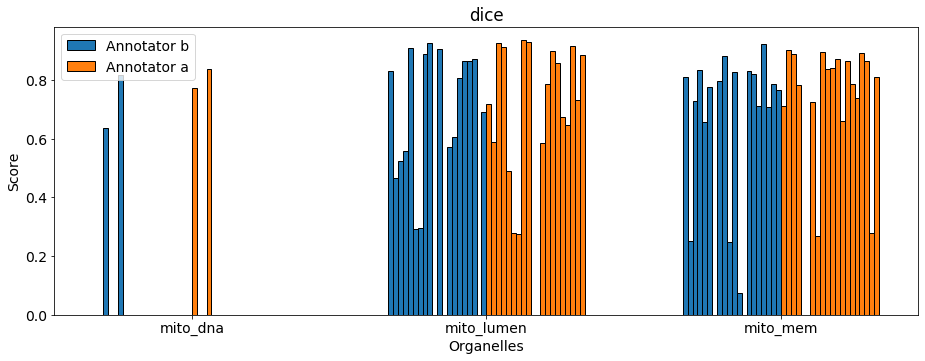

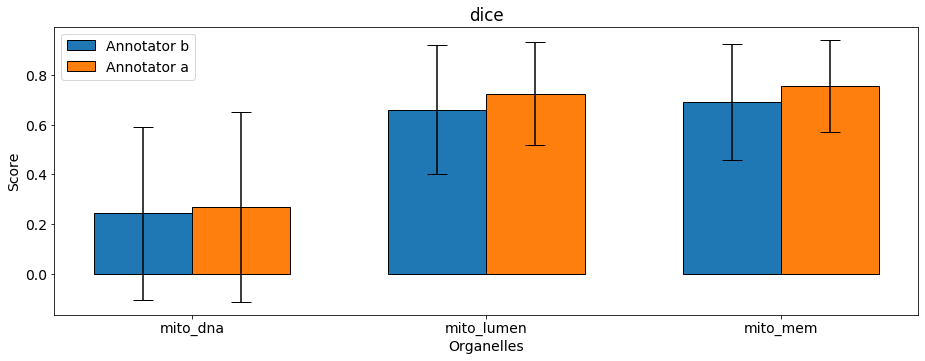

In [67]:
def plot_score(scores_dict, title, do_avg = False):
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
    plt.rc('font', **font)

    if do_avg:
        width = 0.5
    else:
        max_count = 0
        for annotator in scores_dict.keys():
            for organelle in scores_dict[annotator].keys():
                if len(scores_dict[annotator][organelle])>max_count:
                    max_count = len(scores_dict[annotator][organelle])
        width = 1/(len(scores_dict)*max_count)

    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1])
    annotator_gap = 0
    annotator_gap_width = 1/len(scores_dict)
    organelle_gap_width = 1.5
    for annotator in scores_dict.keys():
        organelle_gap = 0
        X = []
        Y = []
        YERR = []
        labels = []
        for organelle,scores in scores_dict[annotator].items():
            if do_avg:
                X.append(annotator_gap+organelle_gap+width/2)
                Y.append(scores[0])
                YERR.append(scores[1])
            else:
                X.extend(width*np.arange(len(scores))+annotator_gap+organelle_gap+width/2)
                Y.extend(scores)
            organelle_gap+=organelle_gap_width
            labels.append(organelle)
        if do_avg:
            ax.bar(X, Y, yerr=YERR, width = width, edgecolor = "black",label=f"Annotator {annotator}",capsize=10)
        else:
            ax.bar(X, Y, width = width, edgecolor = "black",label=f"Annotator {annotator}")
        annotator_gap+=annotator_gap_width
    ax.set_title(title)
    ax.set_xlabel("Organelles")
    ax.set_ylabel("Score")
    ax.set_xticks(np.arange(len(labels))*organelle_gap_width+0.5)
    ax.set_xticklabels(labels)
    ax.legend()

score_name = "dice"
trials = df['Trial'].tolist()
organelles = df['Organelle Name'].tolist()
scores = df[score_name].tolist()
scores_dict = {}

for idx,current_trial in enumerate(trials):
    annotator = current_trial[-1]
    if annotator not in scores_dict:
        scores_dict[annotator] = {}

    organelle = organelles[idx]
    if organelle not in scores_dict[annotator]:
        scores_dict[annotator][organelle] = [scores[idx]]
    else:
        scores_dict[annotator][organelle].append(scores[idx])

plot_score(scores_dict, score_name)

# update to do averages
for annotator in scores_dict.keys():
    for organelle in scores_dict[annotator].keys():
        mean = np.nanmean(scores_dict[annotator][organelle])
        std = np.nanstd(scores_dict[annotator][organelle])
        scores_dict[annotator][organelle] = [mean, std]

plot_score(scores_dict, score_name, do_avg=True)


ipykernel_launcher:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


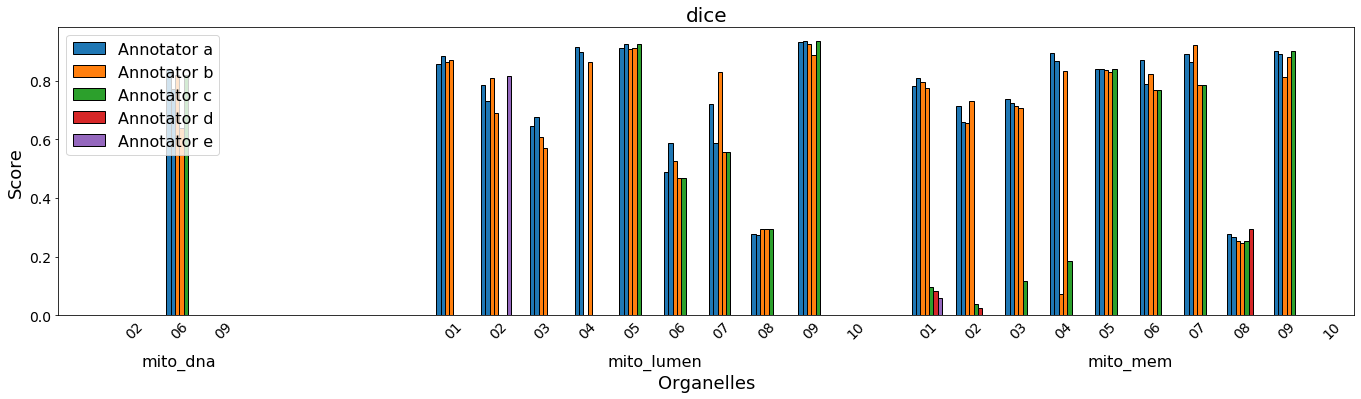

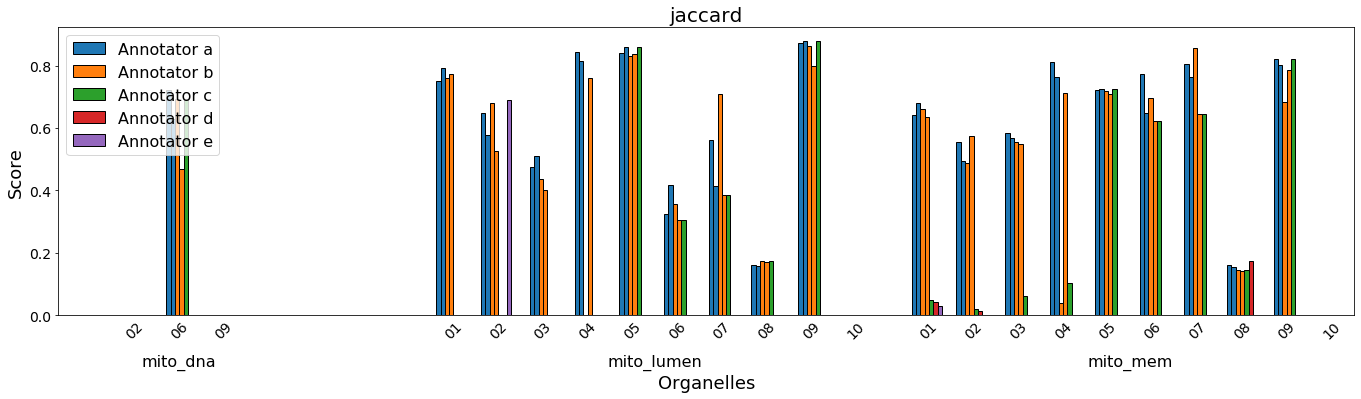

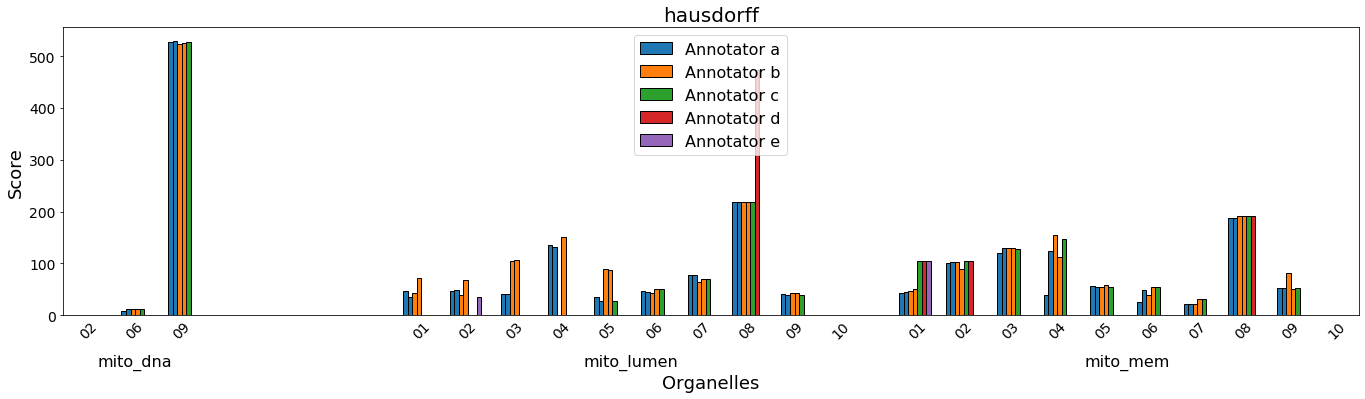

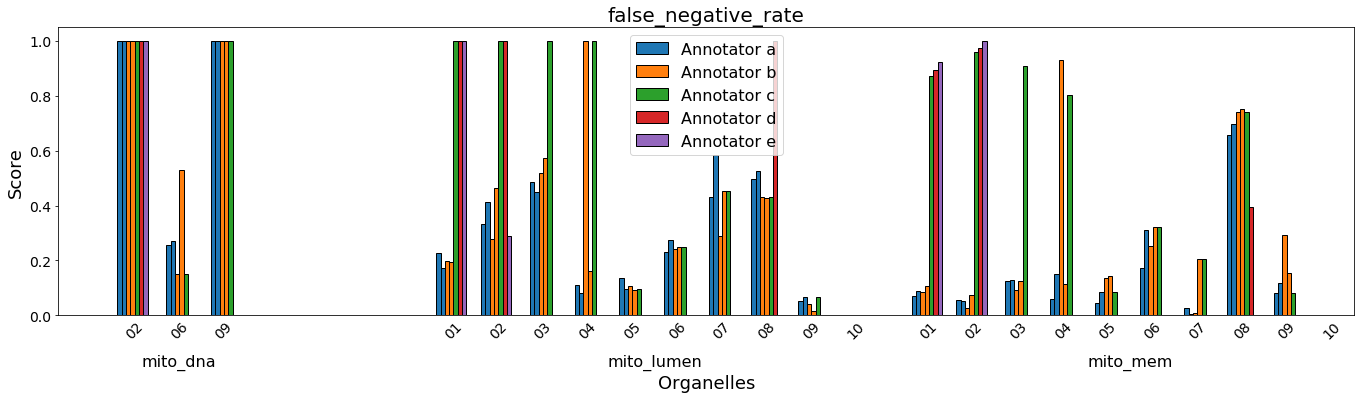

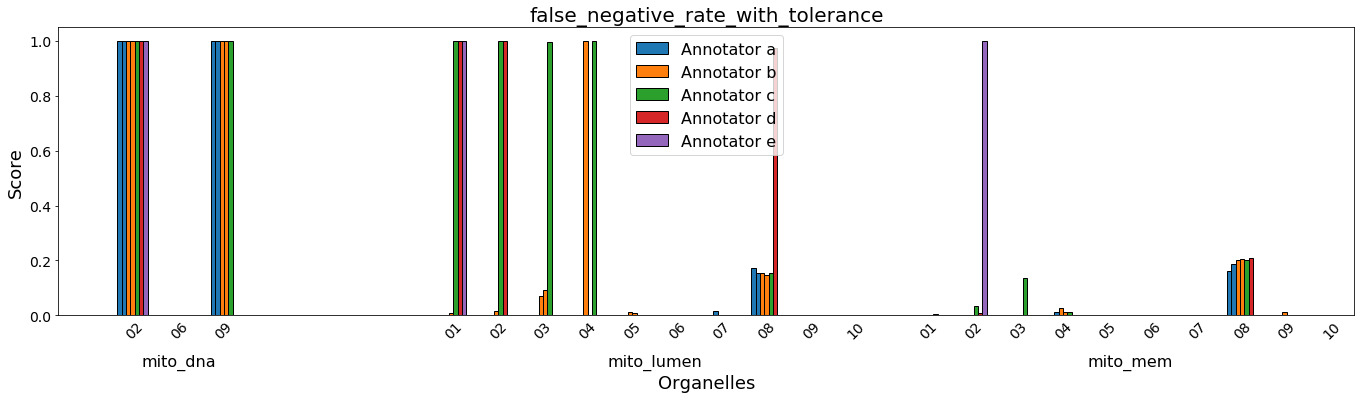

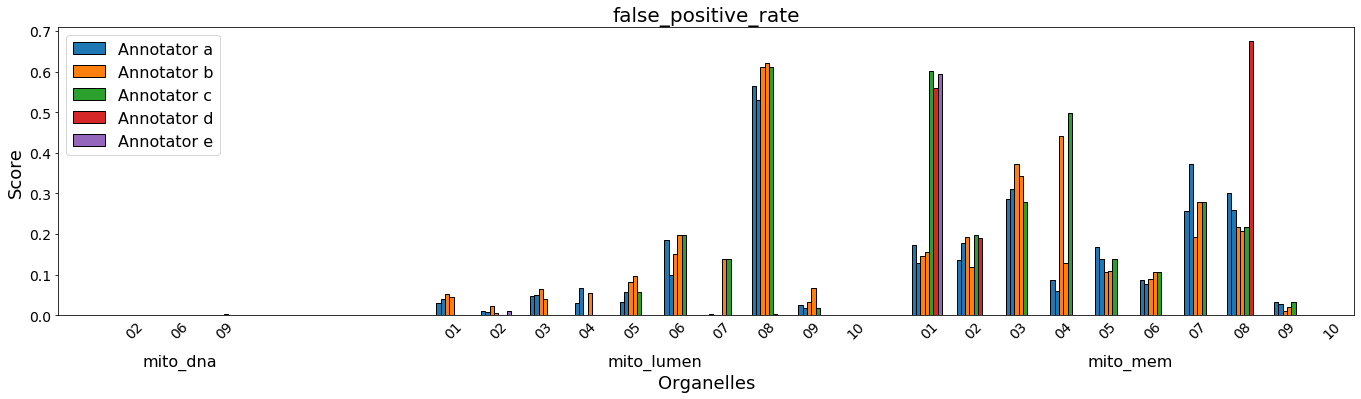

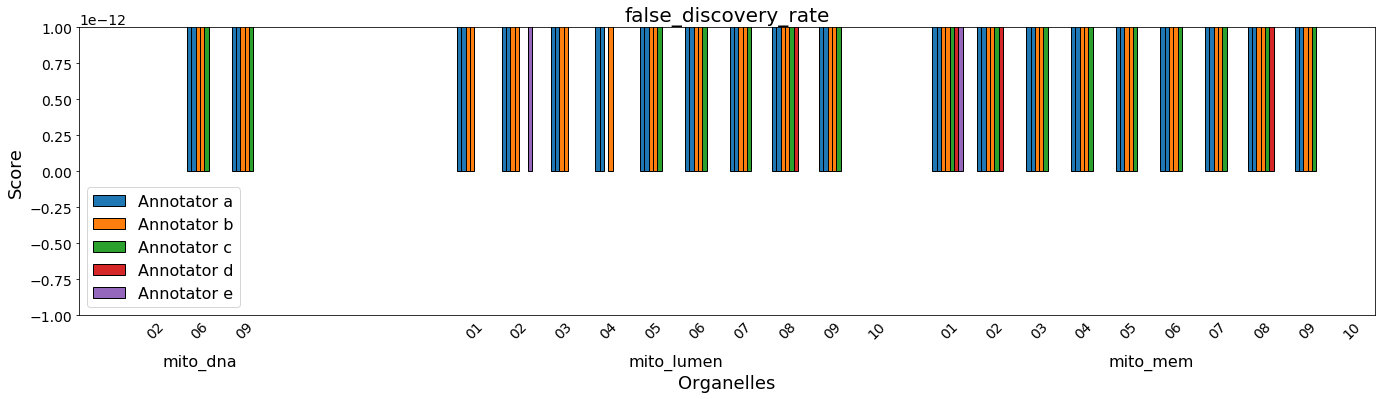

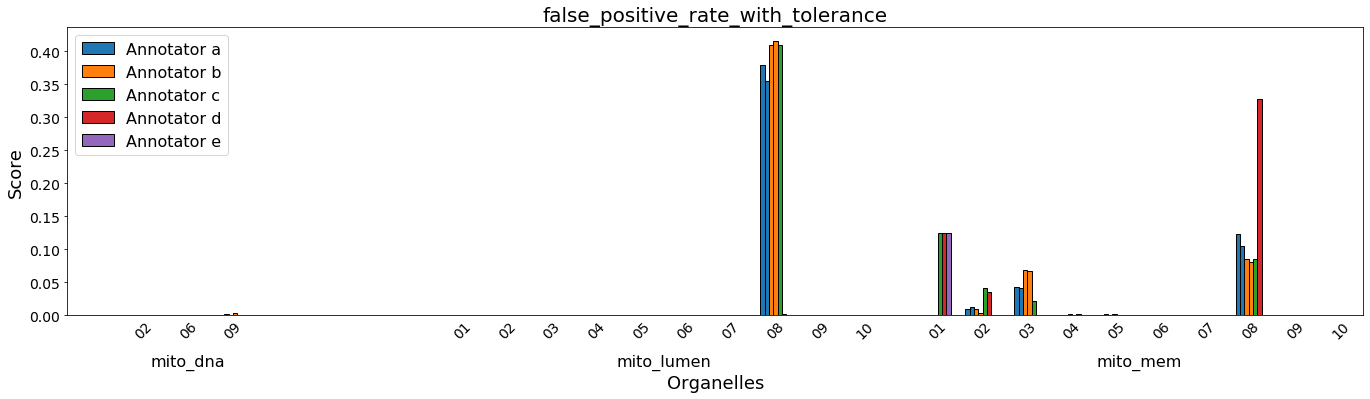

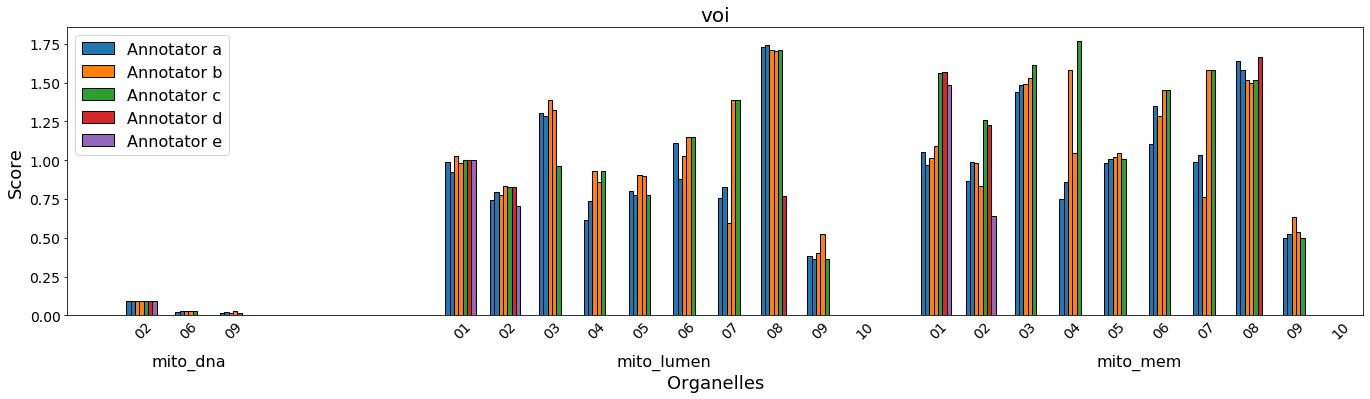

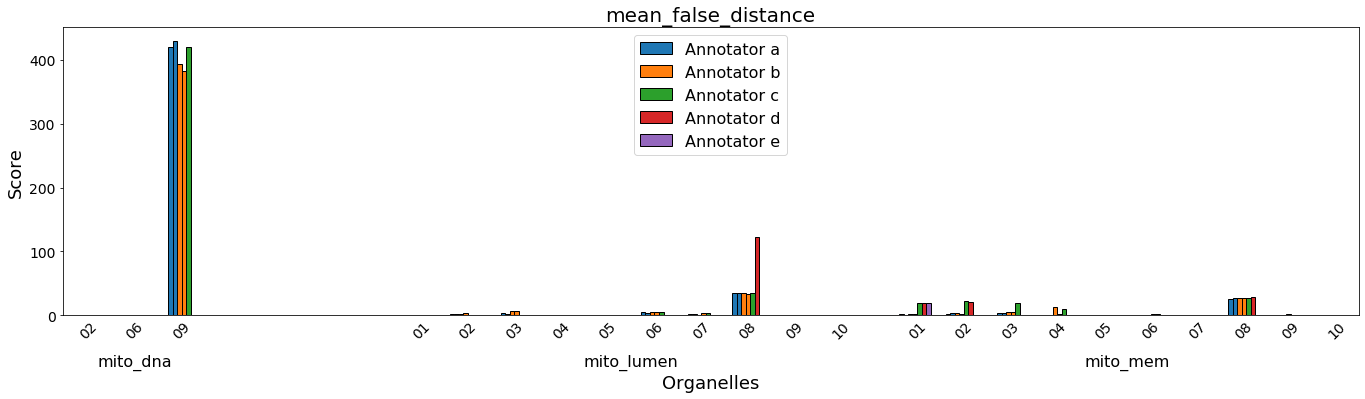

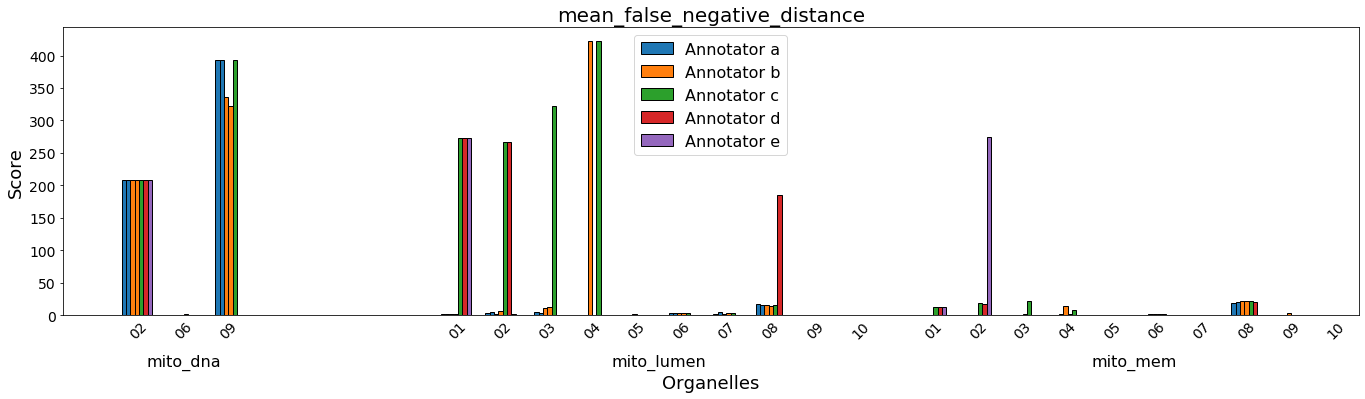

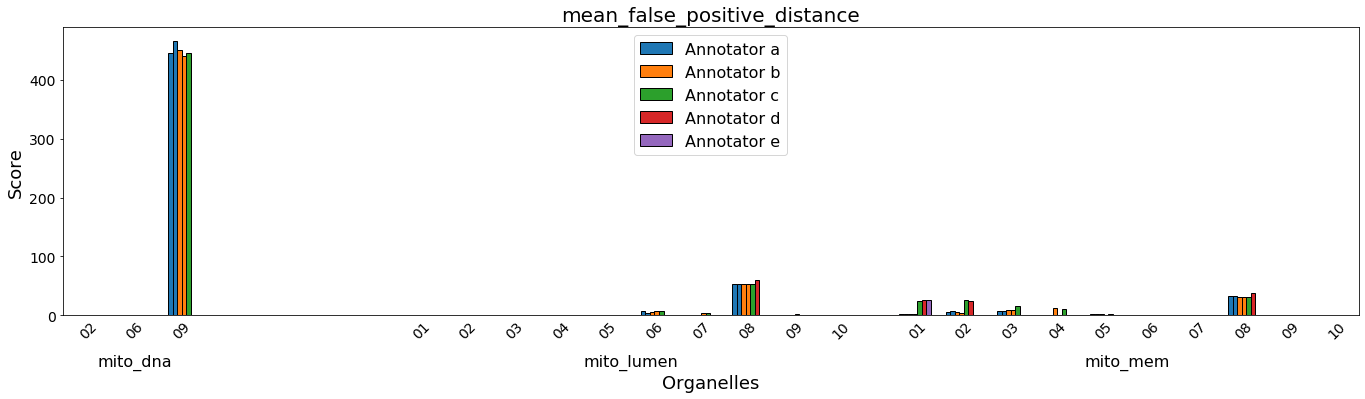

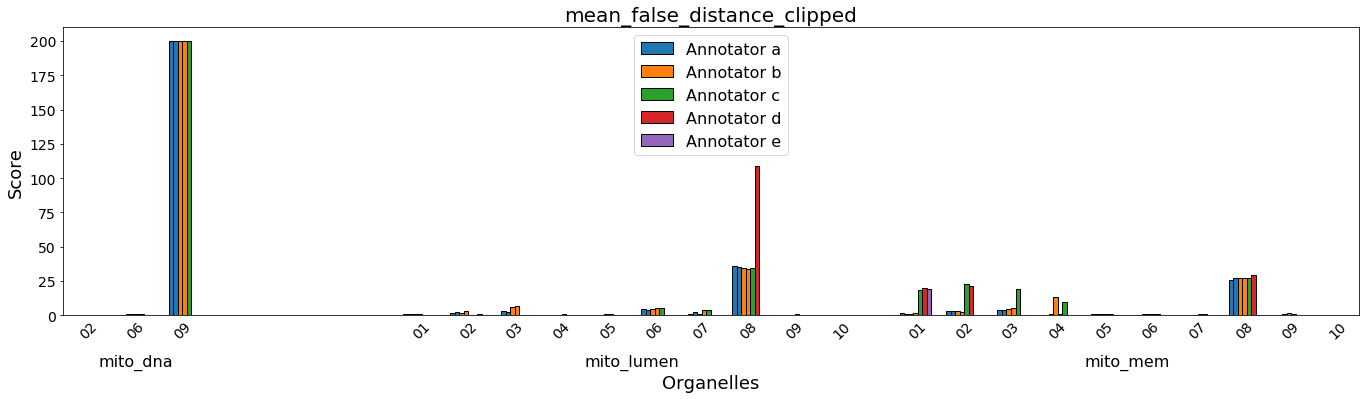

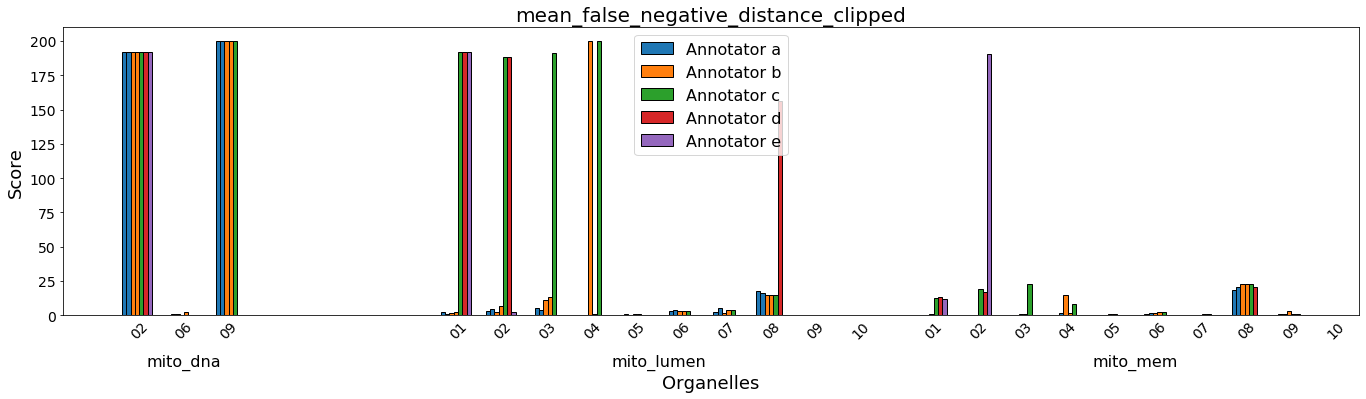

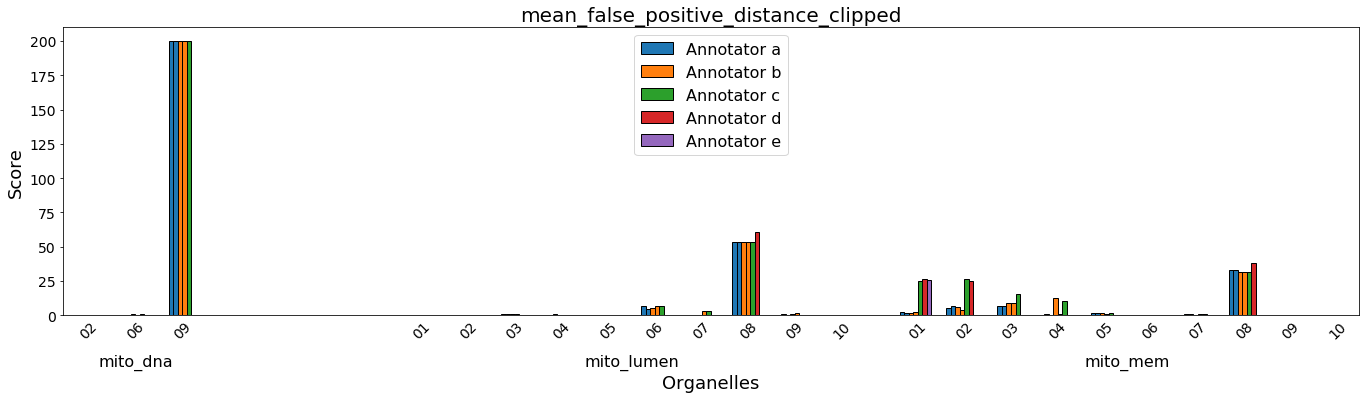

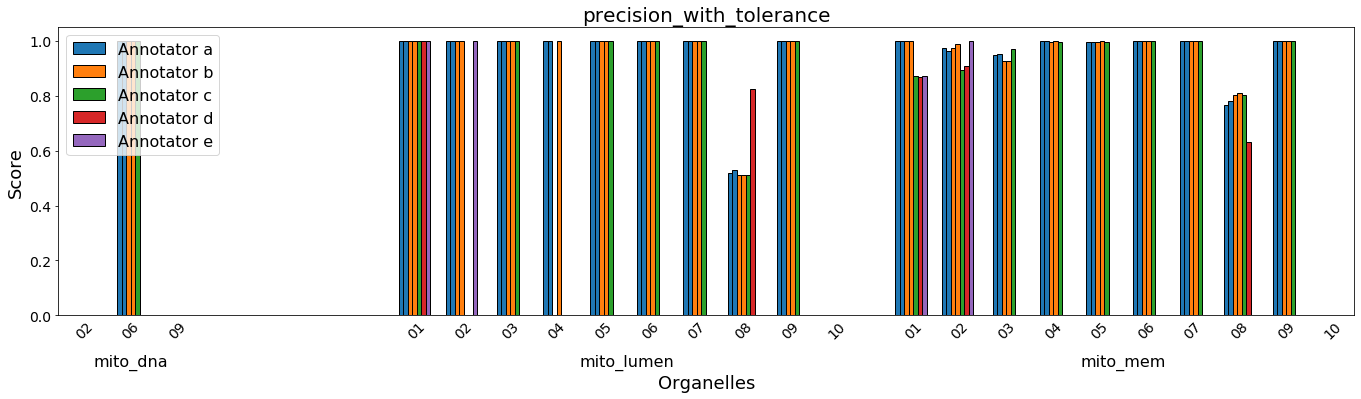

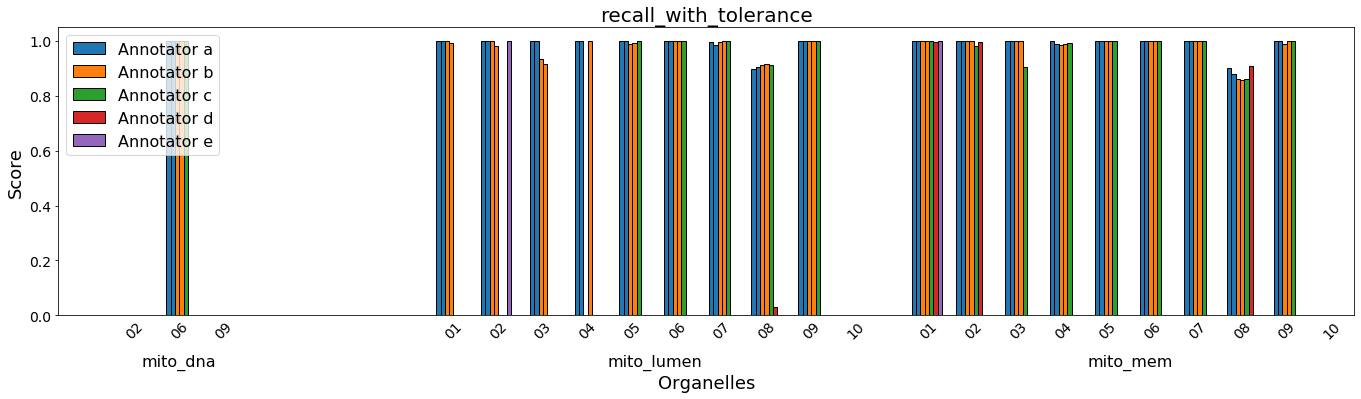

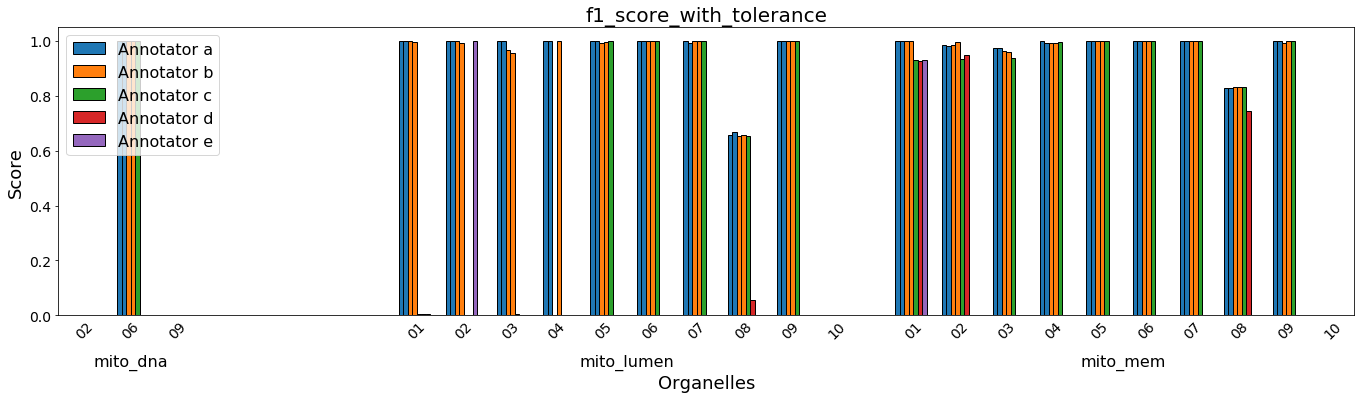

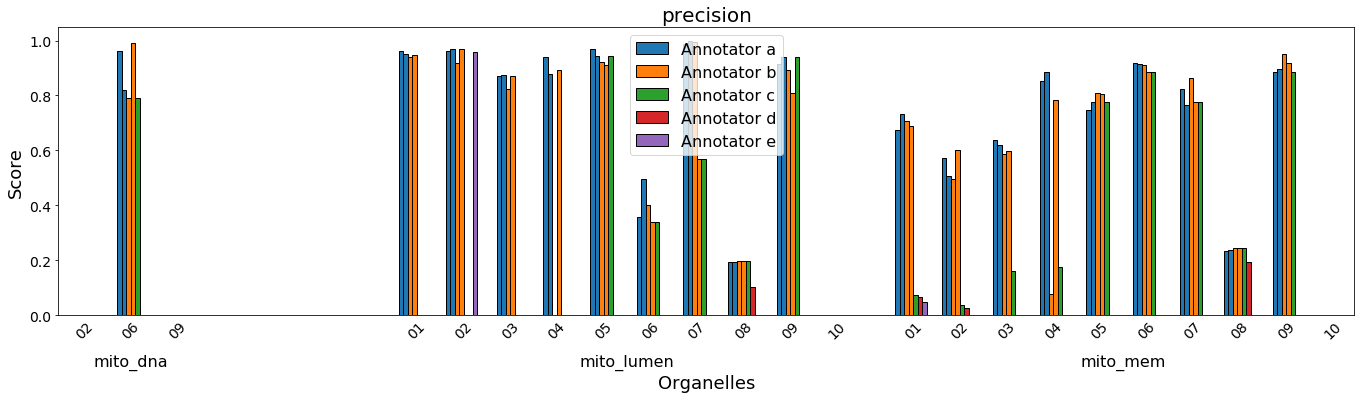

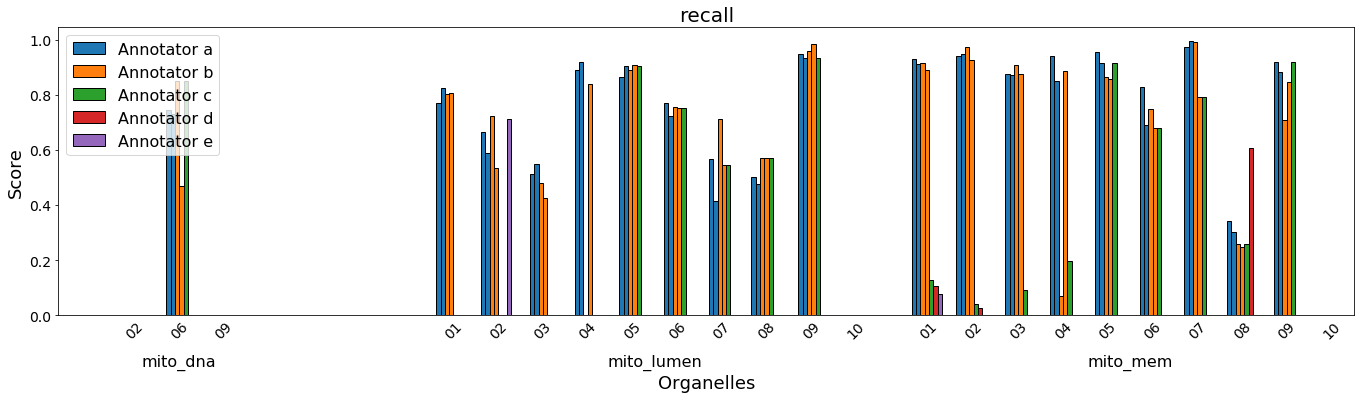

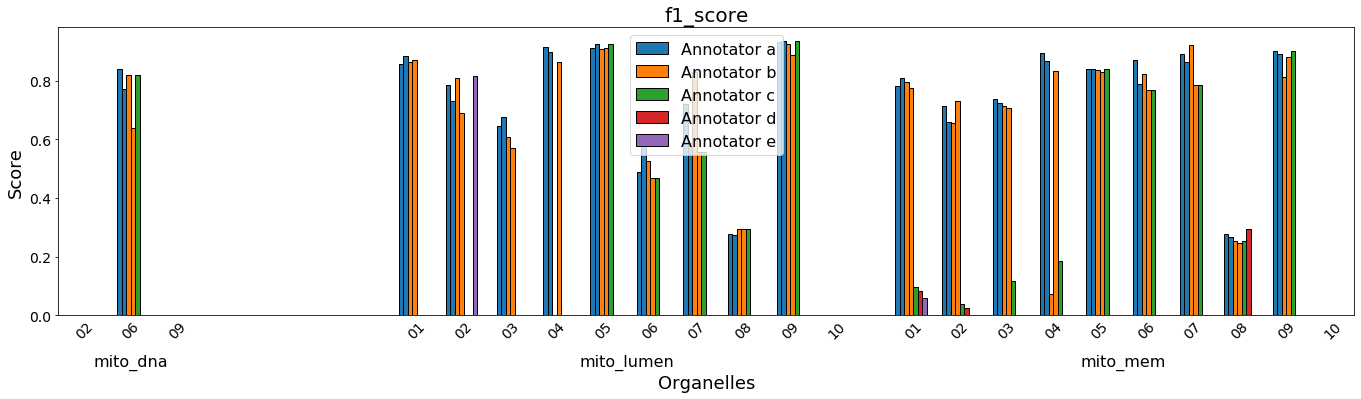

In [156]:
import collections
score_names = df.columns.tolist()[2:]
for score_name in score_names:
    trials = df['Trial'].tolist()
    organelles = df['Organelle Name'].tolist()
    scores = df[score_name].tolist()
    scores_dict = {}

    for idx,current_trial in enumerate(trials):
        crop = current_trial.split("_")[1]
        annotator = current_trial[-1]
        organelle = organelles[idx]
        if organelle not in scores_dict:
            scores_dict[organelle] = {}
        if crop not in scores_dict[organelle]:
            scores_dict[organelle][crop] = {annotator:[scores[idx]]}
        else:
            if annotator not in scores_dict[organelle][crop]:
                scores_dict[organelle][crop][annotator] = [scores[idx]]
            else:
                scores_dict[organelle][crop][annotator].append(scores[idx])

    for organelle in scores_dict.keys():
        for crop in scores_dict[organelle].keys():
            scores_dict[organelle][crop] = collections.OrderedDict(sorted(scores_dict[organelle][crop].items()))
        scores_dict[organelle] = collections.OrderedDict(sorted(scores_dict[organelle].items()))

    # plot
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
    plt.rc('font', **font)

    all_annotators = set()
    max_crops_per_organelle = 0
    max_scores_per_crop_per_annotator = 0
    for organelle in scores_dict.keys():
        scores_per_organelle = 0
        crops_per_organelle = 0
        for crop in scores_dict[organelle].keys():
            crops_per_organelle+=1
            for annotator,scores in scores_dict[organelle][crop].items():
                all_annotators.add(annotator)
                scores_per_crop_per_annotator=len(scores)
                if scores_per_crop_per_annotator>max_scores_per_crop_per_annotator:
                    max_scores_per_crop_per_annotator = scores_per_crop_per_annotator

        if crops_per_organelle>max_crops_per_organelle:
            max_crops_per_organelle = crops_per_organelle

    num_annotators = len(all_annotators)
    organelle_width = 1.5
    organelle_gap = 0.1
    crop_gap = 0.005
    crop_width = (organelle_width-(max_crops_per_organelle-1)*crop_gap)/max_crops_per_organelle
    width = crop_width/(num_annotators*max_scores_per_crop_per_annotator)

    fig = plt.figure()
    ax = fig.add_axes([0,0,3,1])
    X = {}
    Y = {}
    labels = []
    labels_x = []
    organelle_start = 0
    for organelle in scores_dict.keys():
        labels_x.append(organelle_start+0.5*organelle_width)
        labels.append(f"\n\n{organelle}")
        for crop_idx,crop in enumerate(scores_dict[organelle].keys()):
            num_crops = len(scores_dict[organelle])
            crop_start = (crop_width+crop_gap)*crop_idx+organelle_start
            centered_crop_start = crop_start + organelle_width/2 - (crop_width*num_crops+crop_gap*(num_crops-1))/2
            labels_x.append(centered_crop_start+0.5*crop_width)
            labels.append(crop)

            num_scores_for_crop = 0
            for annotator in scores_dict[organelle][crop].keys():
                num_scores_for_crop += len(scores_dict[organelle][crop][annotator])
            annotator_start = centered_crop_start + crop_width/2 - num_scores_for_crop*width/2
            for annotator_idx,annotator in enumerate(scores_dict[organelle][crop].keys()):
                if annotator not in X:
                    X[annotator] = []
                    Y[annotator] = []
                scores = scores_dict[organelle][crop][annotator]
                X[annotator].extend(annotator_start+width*np.arange(len(scores)))
                annotator_start+=width*len(scores)
                Y[annotator].extend(scores)
        organelle_start+=organelle_width+organelle_gap
    for annotator in X.keys():
        ax.bar(X[annotator], Y[annotator], width = width, edgecolor = "black",label=f"Annotator {annotator}")

    ax.legend(prop={'size':16})
    ax.set_title(score_name, size=20)
    ax.set_xlabel("Organelles",size=18)
    ax.set_ylabel("Score",size=18)
    ax.set_xticks(labels_x)
    ax.set_xticklabels(labels)
    # hide tick lines for x axis
    ax.tick_params(axis='x', which='both',length=0)
    for label in ax.get_xmajorticklabels():
        if '0' in label.get_text(): 
            label.set_rotation(45)
        else:
            label.set_fontsize(16)
    plt.savefig(f'plots/{score_name}.png',bbox_inches='tight')
#ax.set_xlim(0,6)

In [118]:
df.columns.tolist()[2:]

['dice',
 'jaccard',
 'hausdorff',
 'false_negative_rate',
 'false_negative_rate_with_tolerance',
 'false_positive_rate',
 'false_discovery_rate',
 'false_positive_rate_with_tolerance',
 'voi',
 'mean_false_distance',
 'mean_false_negative_distance',
 'mean_false_positive_distance',
 'mean_false_distance_clipped',
 'mean_false_negative_distance_clipped',
 'mean_false_positive_distance_clipped',
 'precision_with_tolerance',
 'recall_with_tolerance',
 'f1_score_with_tolerance',
 'precision',
 'recall',
 'f1_score']